In [2]:
# 1.9版本采用树模型，特征工程上没有采用序列特征
# 数据上用到了账号、素材1,2,3,4,5,6,7,10窗口期的数据

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from numpy import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers,datasets
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow import keras
import gc
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import category_encoders as ce
from sklearn.metrics import f1_score,classification_report,roc_auc_score

In [2]:
pd.set_option('display.max_columns', None)

In [565]:
plan_info = pd.read_csv('./ptom_third_plan.csv')
plan_info.dropna(how='all', inplace=True, axis=1)
plan_info.drop(['ad_start_time', 'ad_end_time', 'remark','origin'], axis=1, inplace=True)
plan_info.dropna(subset=['ad_info'],inplace=True)
plan_info.drop(['ad_id', 'ad_group_id', 'ad_name','media_id','plan_id','launch_op_id','bid_mode','bid_status','bid',
                'budget_mode','budget','opt_status','status','syn_time','update_time','inventory_type'], axis=1, inplace=True)
# 解析json
plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
temp = plan_info['ad_info'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('ad_info', axis=1, inplace=True)
temp = plan_info['audience'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('audience', axis=1, inplace=True)
temp = plan_info['action'].apply(pd.Series)
plan_info = pd.concat([plan_info,temp], axis=1)
plan_info.drop('action', axis=1, inplace=True)
plan_info.dropna(how='all', inplace=True, axis=1)

plan_info_2 = plan_info.copy()
plan_info_2.drop(['game_package_batch_id','advanced_creative_type','game_package_desc','game_package_thumbnail_ids',
               'external_url','intelligent_flow_switch','audience_package_id','union_video_type','converted_time_duration',
               'roi_goal','device_type','deep_bid_type','auto_extend_targets'],axis=1,inplace=True)
plan_info_2.drop(['package','open_url','ad_modify_time','deep_cpabid','download_url','download_mode','id','campaign_id',
               'package','ad_create_time','start_time','ad_id','name','status','modify_time','advertiser_id','schedule_type','quick_app_url',
               'end_time','convert_id','audit_reject_reason','download_type','budget_mode','bid','pricing',
               'include_custom_actions','app_type','exclude_flow_package','aweme_fan_behaviors','business_ids','user_type',
               'activate_type','aweme_fan_accounts','aweme_fan_categories','aweme_fans_numbers','article_category',
                'flow_package','carrier','superior_popularity_type','device_brand','exclude_custom_actions','geolocation',
               'opt_status','learning_phase','district'],axis=1,inplace=True)
# 删除老版兴趣行为定向
plan_info_2.drop(['ad_tag','interest_tags','app_behavior_target','app_category','app_ids'],axis=1,inplace=True)
# 删除老版兴趣行为定向
plan_info_2.drop(['retargeting_tags'],axis=1,inplace=True)

In [796]:
plan_info_2.columns

Index(['ad_account_id', 'game_id', 'channel_id', 'source_id', 'bid2',
       'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
       'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
       'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
       'gender', 'city', 'platform', 'launch_price',
       'retargeting_tags_exclude', 'interest_categories', 'interest_words',
       'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
       'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
       'action_categories', 'action_days', 'action_scene', 'action_words'],
      dtype='object')

In [516]:
# plan_info_2.drop(['create_time'],axis=1,inplace=True)

In [566]:
image_info = pd.read_csv('./image_info.csv')

In [567]:
image_info.rename(columns={'create_time':'create_date'},inplace=True)

In [792]:
df = pd.merge(plan_info_2,image_info,on=['channel_id','source_id'],how='left')
df.dropna(subset=['image_id'],inplace=True)

In [496]:
# df.rename(columns={'create_time_x':'create_time','create_time_y':'create_date'},inplace=True)
# df = df[['ad_account_id', 'game_id', 'channel_id', 'source_id', 'create_time','create_date',
#          'bid2','budget','inventory_type', 'schedule_time', 'delivery_range','flow_control_mode',
#         'smart_bid_type', 'adjust_cpa', 'cpa_bid', 'hide_if_exists', 'hide_if_converted',
#         'auto_extend_enabled', 'age','gender', 'city', 'location_type', 'platform', 'launch_price','retargeting_type',
#          'retargeting_tags_include','retargeting_tags_exclude', 'ac', 'android_osv','ios_osv', 
#         'interest_action_mode', 'interest_categories', 'interest_words',
#        'action_categories', 'action_days', 'action_scene', 'action_words',
#        'image_id', 'label_ids']]

In [793]:
launch_report = pd.read_csv('./launch_report.csv',usecols=['tdate','channel_id', 'source_id', 'amount',
       'create_role_num', 'pay_role_user_num', 'new_role_money'])
launch_report.sort_values(by='tdate',inplace=True)
launch_report.drop_duplicates(subset=['channel_id','source_id'],keep='first',inplace=True)
df = pd.merge(df, launch_report,on=['channel_id','source_id'],how='left')
df.drop(df[df['tdate'].isna()].index,inplace=True)

In [794]:
df['create_role_pay_cost'] = df.apply(lambda x:np.inf if x.pay_role_user_num==0 else x.amount/x.pay_role_user_num, axis=1)

In [795]:
df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']":1,"['IOS']":2})

In [ ]:
df['label'] = df.apply(lambda x: 1 if (x.pay_role_user_num>0)&(x.amount>=500)&(x.platform==1)&(x.create_role_pay_cost<=4500)
                      else (1 if (x.pay_role_user_num>0)&(x.amount>=500)&(x.platform==2)&(x.create_role_pay_cost<=6500) else 0),axis=1)

In [573]:
# df['label'] = df.apply(lambda x: 1 if (x.pay_role_user_num>0)&(x.amount>=500)&(x.platform==1)&(x.create_role_pay_cost<=4500)
#                       else (1 if (x.pay_role_user_num>0)&(x.amount>=500)&(x.platform==2)&(x.create_role_pay_cost<=6500) else 0),axis=1)

In [574]:
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
# df['create_date'] = pd.to_datetime(df['create_date']).dt.date
df['create_date'] = pd.to_datetime(df['create_date']).dt.date


In [575]:
# 读取image不同窗口期的运营数据
im_train_data_1 = pd.read_csv('./im_data/train_data_1.csv')
im_train_data_2 = pd.read_csv('./im_data/train_data_2.csv')
im_train_data_3 = pd.read_csv('./im_data/train_data_3.csv')
im_train_data_4 = pd.read_csv('./im_data/train_data_4.csv')
im_train_data_5 = pd.read_csv('./im_data/train_data_5.csv')
im_train_data_6 = pd.read_csv('./im_data/train_data_6.csv')
im_train_data_7 = pd.read_csv('./im_data/train_data_7.csv')
im_train_data_10 = pd.read_csv('./im_data/train_data_10.csv')

In [576]:
for i in [1,2,3,4,5,6,7,10]:
    exec("im_train_data_%d.drop(['label_ids_%d'],axis=1,inplace=True)"%(i,i))
    exec("im_train_data_%d.rename(columns={'model_run_datetime_%d':'create_date','image_id_%d':'image_id'},inplace=True)"%(i,i,i))
    exec("im_train_data_%d['image_id'] = im_train_data_%d['image_id'].astype('int')"%(i,i))
    exec("im_train_data_%d['create_date'] = pd.to_datetime(im_train_data_%d['create_date']).dt.date"%(i,i))

In [577]:
df = pd.merge(df, im_train_data_1, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_2, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_3, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_4, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_5, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_6, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_7, on=['image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, im_train_data_10, on=['image_id','create_date'],how='left', validate='many_to_one')

In [578]:
df[df['label']==0]['im_pay_rate_3'].mean()

0.02979644756648256

In [579]:
df[df['label']==1]['im_pay_rate_3'].mean()

0.025070528184642688

In [580]:
pd.set_option('display.max_rows',None)

In [581]:
# 读取ad不同窗口期的运营数据
ad_train_data_1 = pd.read_csv('./ad_data/train_data_1.csv')
ad_train_data_2 = pd.read_csv('./ad_data/train_data_2.csv')
ad_train_data_3 = pd.read_csv('./ad_data/train_data_3.csv')
ad_train_data_4 = pd.read_csv('./ad_data/train_data_4.csv')
ad_train_data_5 = pd.read_csv('./ad_data/train_data_5.csv')
ad_train_data_6 = pd.read_csv('./ad_data/train_data_6.csv')
ad_train_data_7 = pd.read_csv('./ad_data/train_data_7.csv')
ad_train_data_10 = pd.read_csv('./ad_data/train_data_10.csv')

In [582]:
for i in [1,2,3,4,5,6,7,10]:
    exec("ad_train_data_%d.rename(columns={'model_run_datetime':'create_date'},inplace=True)"%(i))
    exec("ad_train_data_%d['ad_account_id'] = ad_train_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("ad_train_data_%d['create_date'] = pd.to_datetime(ad_train_data_%d['create_date']).dt.date"%(i,i))

In [583]:
df = pd.merge(df, ad_train_data_1, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_2, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_3, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_4, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_5, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_6, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_7, on=['ad_account_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_train_data_10, on=['ad_account_id','create_date'],how='left', validate='many_to_one')

In [584]:
# 读取ad_im不同窗口期的运营数据
ad_im_train_data_1 = pd.read_csv('./ad_im_data/train_data_1.csv')
ad_im_train_data_2 = pd.read_csv('./ad_im_data/train_data_2.csv')
ad_im_train_data_3 = pd.read_csv('./ad_im_data/train_data_3.csv')
ad_im_train_data_4 = pd.read_csv('./ad_im_data/train_data_4.csv')
ad_im_train_data_5 = pd.read_csv('./ad_im_data/train_data_5.csv')
ad_im_train_data_6 = pd.read_csv('./ad_im_data/train_data_6.csv')
ad_im_train_data_7 = pd.read_csv('./ad_im_data/train_data_7.csv')

In [585]:
for i in [1,2,3,4,5,6,7]: 
    exec("ad_im_train_data_%d.rename(columns={'model_run_datetime':'create_date','image_id_%d':'image_id'},inplace=True)"%(i,i))
    exec("ad_im_train_data_%d['image_id'] = ad_im_train_data_%d['image_id'].astype('int')"%(i,i))
    exec("ad_im_train_data_%d['ad_account_id'] = ad_im_train_data_%d['ad_account_id'].astype('int')"%(i,i))
    exec("ad_im_train_data_%d['create_date'] = pd.to_datetime(ad_im_train_data_%d['create_date']).dt.date"%(i,i))

In [586]:
df = pd.merge(df, ad_im_train_data_1, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_2, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_3, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_4, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_5, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_6, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')
df = pd.merge(df, ad_im_train_data_7, on=['ad_account_id','image_id','create_date'],how='left', validate='many_to_one')

In [587]:
df.head()

,ad_account_id,game_id,channel_id,source_id,bid2,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,interest_words,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,action_words,image_id,create_date,label_ids,tdate,amount,create_role_num,pay_role_user_num,new_role_money,create_role_pay_cost,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_2,im_create_role_num_2,im_new_role_money_2,im_pay_role_user_num_2,im_source_num_2,im_valid_source_num_2,im_pay_rate_2,im_create_role_cost_2,im_create_role_pay_cost_2,im_valid_source_rate_2,image_create_role_roi_2,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_4,im_create_role_num_4,im_new_role_money_4,im_pay_role_user_num_4,im_source_num_4,im_valid_source_num_4,im_pay_rate_4,im_create_role_cost_4,im_create_role_pay_cost_4,im_valid_source_rate_4,image_create_role_roi_4,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_6,im_create_role_num_6,im_new_role_money_6,im_pay_role_user_num_6,im_source_num_6,im_valid_source_num_6,im_pay_rate_6,im_create_role_cost_6,im_create_role_pay_cost_6,im_valid_source_rate_6,image_create_role_roi_6,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,im_amount_10,im_create_role_num_10,im_new_role_money_10,im_pay_role_user_num_10,im_source_num_10,im_valid_source_num_10,im_pay_rate_10,im_create_role_cost_10,im_create_role_pay_cost_10,im_valid_source_rate_10,image_create_role_roi_10,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_2,ad_create_role_num_2,ad_new_role_money_2,ad_pay_role_user_num_2,ad_source_num_2,ad_valid_source_num_2,ad_pay_rate_2,ad_create_role_cost_2,ad_create_role_pay_cost_2,ad_valid_source_rate_2,ad_create_role_roi_2,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_4,ad_create_role_num_4,ad_new_role_money_4,ad_pay_role_user_num_4,ad_source_num_4,ad_valid_source_num_4,ad_pay_rate_4,ad_create_role_cost_4,ad_create_role_pay_cost_4,ad_valid_source_rate_4,ad_create_role_roi_4,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_6,ad_create_role_num_6,ad_new_role_money_6,ad_pay_role_user_num_6,ad_source_num_6,ad_valid_source_num_6,ad_pay_rate_6,ad_create_role_cost_6,ad_create_role_pay_cost_6,ad_valid_source_rate_6,ad_create_role_roi_6,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_amount_10,ad_create_role_num_10,ad_new_role_money_10,ad_pay_role_user_n

In [589]:
# df.drop(['inventory_type','schedule_time','delivery_range','flow_control_mode',
#             'smart_bid_type','hide_if_converted','age','gender','city','location_type','platform','launch_price','retargeting_type',
#             'retargeting_tags_include','retargeting_tags_exclude','ac','android_osv','ios_osv','interest_action_mode',
#             'interest_categories','action_categories','action_days','action_scene','label_ids'],axis=1,inplace=True)
df.drop(['interest_words','action_words','budget','bid2','cpa_bid'],axis=1,inplace=True)

df.drop(['create_role_num','amount','pay_role_user_num','new_role_money','create_role_pay_cost'],axis=1,inplace=True)
df.drop(['channel_id','source_id','tdate','create_date'],axis=1,inplace=True)

In [359]:
# df.drop(['adjust_cpa','hide_if_exists','auto_extend_enabled'],axis=1,inplace=True)

In [590]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,image_id,create_date,label_ids,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_2,im_create_role_num_2,im_new_role_money_2,im_pay_role_user_num_2,im_source_num_2,im_valid_source_num_2,im_pay_rate_2,im_create_role_cost_2,im_create_role_pay_cost_2,im_valid_source_rate_2,image_create_role_roi_2,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_4,im_create_role_num_4,im_new_role_money_4,im_pay_role_user_num_4,im_source_num_4,im_valid_source_num_4,im_pay_rate_4,im_create_role_cost_4,im_create_role_pay_cost_4,im_valid_source_rate_4,image_create_role_roi_4,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_6,im_create_role_num_6,im_new_role_money_6,im_pay_role_user_num_6,im_source_num_6,im_valid_source_num_6,im_pay_rate_6,im_create_role_cost_6,im_create_role_pay_cost_6,im_valid_source_rate_6,image_create_role_roi_6,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,im_amount_10,im_create_role_num_10,im_new_role_money_10,im_pay_role_user_num_10,im_source_num_10,im_valid_source_num_10,im_pay_rate_10,im_create_role_cost_10,im_create_role_pay_cost_10,im_valid_source_rate_10,image_create_role_roi_10,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_2,ad_create_role_num_2,ad_new_role_money_2,ad_pay_role_user_num_2,ad_source_num_2,ad_valid_source_num_2,ad_pay_rate_2,ad_create_role_cost_2,ad_create_role_pay_cost_2,ad_valid_source_rate_2,ad_create_role_roi_2,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_4,ad_create_role_num_4,ad_new_role_money_4,ad_pay_role_user_num_4,ad_source_num_4,ad_valid_source_num_4,ad_pay_rate_4,ad_create_role_cost_4,ad_create_role_pay_cost_4,ad_valid_source_rate_4,ad_create_role_roi_4,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_6,ad_create_role_num_6,ad_new_role_money_6,ad_pay_role_user_num_6,ad_source_num_6,ad_valid_source_num_6,ad_pay_rate_6,ad_create_role_cost_6,ad_create_role_pay_cost_6,ad_valid_source_rate_6,ad_create_role_roi_6,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_amount_10,ad_create_role_num_10,ad_new_role_money_10,ad_pay_role_user_num_10,ad_source_num_10,ad_valid_source_num_10,ad_pay_rate_10,ad_create_role_cost_10,ad_create_role_pay_cost_10,ad_valid_source_rate_10,ad_create_role_ro

In [591]:
cost_col = ['im_create_role_cost_1','im_create_role_cost_2','im_create_role_cost_3','im_create_role_cost_4',
            'im_create_role_cost_5','im_create_role_cost_6','im_create_role_cost_7','im_create_role_cost_10',
            'ad_create_role_cost_1','ad_create_role_cost_2','ad_create_role_cost_3','ad_create_role_cost_4',
            'ad_create_role_cost_5','ad_create_role_cost_6','ad_create_role_cost_7','ad_create_role_cost_10',
           'ad_im_create_role_cost_1','ad_im_create_role_cost_2','ad_im_create_role_cost_3','ad_im_create_role_cost_4',
            'ad_im_create_role_cost_5','ad_im_create_role_cost_6','ad_im_create_role_cost_7']
for col in cost_col:
    df[col] = df[col].apply(lambda x:x if x>0 else np.inf)

In [593]:
df['create_time'] = pd.to_datetime(df['create_time'])

In [594]:
df['ad_im_sort_id'] = df.groupby(['ad_account_id','image_id'])['create_time'].rank()
df['ad_game_sort_id'] = df.groupby(['ad_account_id','game_id'])['create_time'].rank()

In [595]:
df['im_ad_sort_id'] = df.groupby(['image_id','ad_account_id'])['create_time'].rank()

In [188]:
# # 对列表内容进行编码降维
# def get_mutil_feature(data):
#     cols = ['inventory_type','age','city','retargeting_tags_include','retargeting_tags_exclude','ac','interest_categories',
#        'action_scene','action_categories']
#     for col in cols:
#         if col in ['inventory_type','age']:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
#             data.drop(col,axis=1,inplace=True)
#         elif col in ['city','retargeting_tags_include','retargeting_tags_exclude','interest_categories','action_categories']:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data[col]=data[col].apply(lambda x:[str(i) for i in x])
#             temp = data[col].str.join('|').str.get_dummies()
#     #         print(temp.shape[1])
#             pca = PCA(n_components=0.9)
#             temp = pca.fit_transform(temp.values)
#             temp = pd.DataFrame(temp,columns = [col+str(i) for i in range(temp.shape[1])])
#     #         print(temp.shape[1])
#             data = data.join(temp)
#             del temp
#             data.drop(col,axis=1,inplace=True)
#         else:
#             data[col] = data[col].apply(lambda x:x if x==x else [])
#             data[col]=data[col].apply(lambda x:[str(i) for i in x])
#             data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col+'_'))
#             data.drop(col,axis=1,inplace=True)
    
#     gc.collect()
#     return data

In [191]:
# %%time
# df = get_mutil_feature(df)

Wall time: 51.7 s


In [596]:
df.shape

(28562, 289)

In [597]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,image_id,create_date,label_ids,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_2,im_create_role_num_2,im_new_role_money_2,im_pay_role_user_num_2,im_source_num_2,im_valid_source_num_2,im_pay_rate_2,im_create_role_cost_2,im_create_role_pay_cost_2,im_valid_source_rate_2,image_create_role_roi_2,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_4,im_create_role_num_4,im_new_role_money_4,im_pay_role_user_num_4,im_source_num_4,im_valid_source_num_4,im_pay_rate_4,im_create_role_cost_4,im_create_role_pay_cost_4,im_valid_source_rate_4,image_create_role_roi_4,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_6,im_create_role_num_6,im_new_role_money_6,im_pay_role_user_num_6,im_source_num_6,im_valid_source_num_6,im_pay_rate_6,im_create_role_cost_6,im_create_role_pay_cost_6,im_valid_source_rate_6,image_create_role_roi_6,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,im_amount_10,im_create_role_num_10,im_new_role_money_10,im_pay_role_user_num_10,im_source_num_10,im_valid_source_num_10,im_pay_rate_10,im_create_role_cost_10,im_create_role_pay_cost_10,im_valid_source_rate_10,image_create_role_roi_10,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_2,ad_create_role_num_2,ad_new_role_money_2,ad_pay_role_user_num_2,ad_source_num_2,ad_valid_source_num_2,ad_pay_rate_2,ad_create_role_cost_2,ad_create_role_pay_cost_2,ad_valid_source_rate_2,ad_create_role_roi_2,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_4,ad_create_role_num_4,ad_new_role_money_4,ad_pay_role_user_num_4,ad_source_num_4,ad_valid_source_num_4,ad_pay_rate_4,ad_create_role_cost_4,ad_create_role_pay_cost_4,ad_valid_source_rate_4,ad_create_role_roi_4,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_6,ad_create_role_num_6,ad_new_role_money_6,ad_pay_role_user_num_6,ad_source_num_6,ad_valid_source_num_6,ad_pay_rate_6,ad_create_role_cost_6,ad_create_role_pay_cost_6,ad_valid_source_rate_6,ad_create_role_roi_6,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_amount_10,ad_create_role_num_10,ad_new_role_money_10,ad_pay_role_user_num_10,ad_source_num_10,ad_valid_source_num_10,ad_pay_rate_10,ad_create_role_cost_10,ad_create_role_pay_cost_10,ad_valid_source_rate_10,ad_create_role_ro

In [598]:
cat_cols = ['ad_account_id','game_id','inventory_type','schedule_time','delivery_range','flow_control_mode',
            'smart_bid_type','hide_if_converted','age','gender','city','location_type','platform','launch_price','retargeting_type',
            'retargeting_tags_include','retargeting_tags_exclude','ac','android_osv','ios_osv','interest_action_mode',
            'interest_categories','action_categories','action_days','action_scene','image_id','label_ids']
for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [194]:
# cat_cols = ['ad_account_id','game_id','schedule_time','delivery_range','flow_control_mode',
#             'smart_bid_type','hide_if_converted','gender','location_type','launch_price','retargeting_type',
#             'android_osv','ios_osv','interest_action_mode',
#             'action_days','image_id','label_ids']
# for col in cat_cols:
#     df[col] = df[col].astype(str)
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])

In [303]:
df.shape

(28562, 287)

In [599]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,image_id,create_date,label_ids,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_2,im_create_role_num_2,im_new_role_money_2,im_pay_role_user_num_2,im_source_num_2,im_valid_source_num_2,im_pay_rate_2,im_create_role_cost_2,im_create_role_pay_cost_2,im_valid_source_rate_2,image_create_role_roi_2,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_4,im_create_role_num_4,im_new_role_money_4,im_pay_role_user_num_4,im_source_num_4,im_valid_source_num_4,im_pay_rate_4,im_create_role_cost_4,im_create_role_pay_cost_4,im_valid_source_rate_4,image_create_role_roi_4,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_6,im_create_role_num_6,im_new_role_money_6,im_pay_role_user_num_6,im_source_num_6,im_valid_source_num_6,im_pay_rate_6,im_create_role_cost_6,im_create_role_pay_cost_6,im_valid_source_rate_6,image_create_role_roi_6,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,im_amount_10,im_create_role_num_10,im_new_role_money_10,im_pay_role_user_num_10,im_source_num_10,im_valid_source_num_10,im_pay_rate_10,im_create_role_cost_10,im_create_role_pay_cost_10,im_valid_source_rate_10,image_create_role_roi_10,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_2,ad_create_role_num_2,ad_new_role_money_2,ad_pay_role_user_num_2,ad_source_num_2,ad_valid_source_num_2,ad_pay_rate_2,ad_create_role_cost_2,ad_create_role_pay_cost_2,ad_valid_source_rate_2,ad_create_role_roi_2,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_4,ad_create_role_num_4,ad_new_role_money_4,ad_pay_role_user_num_4,ad_source_num_4,ad_valid_source_num_4,ad_pay_rate_4,ad_create_role_cost_4,ad_create_role_pay_cost_4,ad_valid_source_rate_4,ad_create_role_roi_4,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_6,ad_create_role_num_6,ad_new_role_money_6,ad_pay_role_user_num_6,ad_source_num_6,ad_valid_source_num_6,ad_pay_rate_6,ad_create_role_cost_6,ad_create_role_pay_cost_6,ad_valid_source_rate_6,ad_create_role_roi_6,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_amount_10,ad_create_role_num_10,ad_new_role_money_10,ad_pay_role_user_num_10,ad_source_num_10,ad_valid_source_num_10,ad_pay_rate_10,ad_create_role_cost_10,ad_create_role_pay_cost_10,ad_valid_source_rate_10,ad_create_role_ro

In [776]:
test_data = df[df['create_time'] >='2020-11-15']
train_data = df[df['create_time'] <'2020-11-15']

In [760]:
df_an.shape

(11953, 288)

In [761]:
test_data = df_an[df_an['create_time'] >='2020-12-01']
train_data = df_an[(df_an['create_time'] <'2020-12-01')&(df_an['create_time'] >='2020-04-01')]

In [777]:
test_data.drop(['create_time'],axis=1,inplace=True)
train_data.drop(['create_time'],axis=1,inplace=True)

In [778]:
# train_data, test_data = train_test_split(df, test_size=0.25)
target = train_data['label']
features = train_data.drop(['label'], axis=1)
X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [779]:
# 不调参
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.01,
"max_depth":5,
"num_leaves":35,
"min_child_samples":15,
"feature_fraction": 0.5,
"bagging_fraction":0.5,
"bagging_freq":10,
"lambda_l1":10,
"lambda_l2":10,
"metric": "auc",
'is_unbalance':True    
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.692225	valid_1's auc: 0.655544
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.712733	valid_1's auc: 0.670362
[3]	training's auc: 0.73045	valid_1's auc: 0.684805
[4]	training's auc: 0.730311	valid_1's auc: 0.688216
[5]	training's auc: 0.731871	valid_1's auc: 0.691517
[6]	training's auc: 0.737196	valid_1's auc: 0.69862
[7]	training's auc: 0.735668	valid_1's auc: 0.699624
[8]	training's auc: 0.735363	valid_1's auc: 0.700262
[9]	training's auc: 0.737508	valid_1's auc: 0.702926
[10]	training's auc: 0.740369	valid_1's auc: 0.707709
[11]	training's auc: 0.744461	valid_1's auc: 0.711324
[12]	training's auc: 0.746424	valid_1's auc: 0.713477
[13]	training's auc: 0.748639	valid_1's auc: 0.714046
[14]	training's auc: 0.749309	valid_1's auc: 0.714841
[15]	training's auc: 0.750928	valid_1's auc: 0.717029
[16]	training's auc: 0.751614	valid_1's auc: 0.717391
[17]	training's auc: 0.751667	valid_1's auc: 0.718158
[18]	training's auc: 0.751812	v

[167]	training's auc: 0.810575	valid_1's auc: 0.748769
[168]	training's auc: 0.810776	valid_1's auc: 0.748634
[169]	training's auc: 0.811048	valid_1's auc: 0.748734
[170]	training's auc: 0.811267	valid_1's auc: 0.748637
[171]	training's auc: 0.811598	valid_1's auc: 0.748784
[172]	training's auc: 0.811847	valid_1's auc: 0.748952
[173]	training's auc: 0.812054	valid_1's auc: 0.749142
[174]	training's auc: 0.812259	valid_1's auc: 0.749098
[175]	training's auc: 0.812472	valid_1's auc: 0.749189
[176]	training's auc: 0.812642	valid_1's auc: 0.74917
[177]	training's auc: 0.812872	valid_1's auc: 0.749294
[178]	training's auc: 0.81316	valid_1's auc: 0.749397
[179]	training's auc: 0.813466	valid_1's auc: 0.74949
[180]	training's auc: 0.813791	valid_1's auc: 0.749795
[181]	training's auc: 0.814087	valid_1's auc: 0.749862
[182]	training's auc: 0.814278	valid_1's auc: 0.749843
[183]	training's auc: 0.814567	valid_1's auc: 0.749848
[184]	training's auc: 0.814835	valid_1's auc: 0.749827
[185]	trainin

[335]	training's auc: 0.849691	valid_1's auc: 0.757596
[336]	training's auc: 0.8498	valid_1's auc: 0.757726
[337]	training's auc: 0.849911	valid_1's auc: 0.757759
[338]	training's auc: 0.849992	valid_1's auc: 0.757732
[339]	training's auc: 0.850098	valid_1's auc: 0.757777
[340]	training's auc: 0.850194	valid_1's auc: 0.757858
[341]	training's auc: 0.850401	valid_1's auc: 0.757902
[342]	training's auc: 0.850602	valid_1's auc: 0.757877
[343]	training's auc: 0.850734	valid_1's auc: 0.757903
[344]	training's auc: 0.850951	valid_1's auc: 0.757877
[345]	training's auc: 0.851177	valid_1's auc: 0.75787
[346]	training's auc: 0.851399	valid_1's auc: 0.757873
[347]	training's auc: 0.851594	valid_1's auc: 0.757917
[348]	training's auc: 0.851741	valid_1's auc: 0.757927
[349]	training's auc: 0.851898	valid_1's auc: 0.757868
[350]	training's auc: 0.852043	valid_1's auc: 0.757814
[351]	training's auc: 0.852205	valid_1's auc: 0.757723
[352]	training's auc: 0.852418	valid_1's auc: 0.757654
[353]	trainin

[507]	training's auc: 0.881726	valid_1's auc: 0.760578
[508]	training's auc: 0.881905	valid_1's auc: 0.760585
[509]	training's auc: 0.882033	valid_1's auc: 0.760613
[510]	training's auc: 0.882217	valid_1's auc: 0.760596
[511]	training's auc: 0.882348	valid_1's auc: 0.760583
[512]	training's auc: 0.882547	valid_1's auc: 0.760521
[513]	training's auc: 0.882766	valid_1's auc: 0.760436
[514]	training's auc: 0.882938	valid_1's auc: 0.760412
[515]	training's auc: 0.883066	valid_1's auc: 0.760425
[516]	training's auc: 0.883263	valid_1's auc: 0.760449
[517]	training's auc: 0.883395	valid_1's auc: 0.760455
[518]	training's auc: 0.883575	valid_1's auc: 0.760509
[519]	training's auc: 0.88378	valid_1's auc: 0.760428
[520]	training's auc: 0.883973	valid_1's auc: 0.760403
[521]	training's auc: 0.884259	valid_1's auc: 0.760331
[522]	training's auc: 0.884498	valid_1's auc: 0.760295
[523]	training's auc: 0.884705	valid_1's auc: 0.760193
[524]	training's auc: 0.884876	valid_1's auc: 0.76022
[525]	traini

[676]	training's auc: 0.906322	valid_1's auc: 0.760495
[677]	training's auc: 0.906433	valid_1's auc: 0.760501
[678]	training's auc: 0.906477	valid_1's auc: 0.760469
[679]	training's auc: 0.906569	valid_1's auc: 0.760526
[680]	training's auc: 0.906675	valid_1's auc: 0.760454
[681]	training's auc: 0.906776	valid_1's auc: 0.76056
[682]	training's auc: 0.906942	valid_1's auc: 0.760598
[683]	training's auc: 0.90712	valid_1's auc: 0.760651
[684]	training's auc: 0.907248	valid_1's auc: 0.760623
[685]	training's auc: 0.907391	valid_1's auc: 0.760637
[686]	training's auc: 0.907516	valid_1's auc: 0.760648
[687]	training's auc: 0.907678	valid_1's auc: 0.76068
[688]	training's auc: 0.907808	valid_1's auc: 0.760656
[689]	training's auc: 0.907944	valid_1's auc: 0.760639
[690]	training's auc: 0.908057	valid_1's auc: 0.760616
[691]	training's auc: 0.908219	valid_1's auc: 0.760588
[692]	training's auc: 0.908351	valid_1's auc: 0.760601
[693]	training's auc: 0.908485	valid_1's auc: 0.760555
[694]	trainin

In [780]:
# 用train_data_pay_7_test数据集进行测试
target_test = test_data['label']
features_test = test_data.drop(['label'], axis=1)
y_predict = lgb_b.predict(features_test)

In [781]:
roc_auc_score(target_test,y_predict)

0.6378778644361388

In [782]:
s = pd.Series(y_predict)

In [783]:
s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.05)]

0.5929035838266906

In [784]:
int(y_predict.shape[0] *0.05)

282

In [785]:
y_predict.max()

0.7839212673159717

In [786]:
list(map(lambda x:1 if x>=s.sort_values(ascending=False).reset_index(drop=True)[int(y_predict.shape[0] *0.05)] else 0,y_predict)).count(1)

283

In [787]:
y_predict.shape

(5656,)

In [726]:
target_test.shape

(2748,)

In [790]:
target_test.sum()

529

In [788]:
y_predict = list(map(lambda x:1 if x>=0.67381 else 0,y_predict))

In [789]:
print(classification_report(target_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5127
           1       0.19      0.03      0.06       529

    accuracy                           0.90      5656
   macro avg       0.55      0.51      0.50      5656
weighted avg       0.84      0.90      0.86      5656



<Figure size 864x432 with 0 Axes>

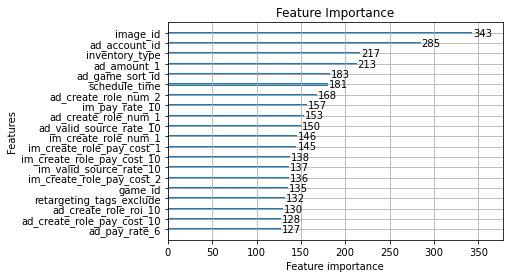

In [791]:
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_b, max_num_features=20)
plt.title('Feature Importance')
plt.show()

In [694]:
test_data.head()

,ad_account_id,game_id,smart_bid_type,hide_if_exists,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,schedule_time,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,image_id,label_ids,label,im_amount_1,im_create_role_num_1,im_new_role_money_1,im_pay_role_user_num_1,im_source_num_1,im_valid_source_num_1,im_pay_rate_1,im_create_role_cost_1,im_create_role_pay_cost_1,im_valid_source_rate_1,image_create_role_roi_1,im_amount_2,im_create_role_num_2,im_new_role_money_2,im_pay_role_user_num_2,im_source_num_2,im_valid_source_num_2,im_pay_rate_2,im_create_role_cost_2,im_create_role_pay_cost_2,im_valid_source_rate_2,image_create_role_roi_2,im_amount_3,im_create_role_num_3,im_new_role_money_3,im_pay_role_user_num_3,im_source_num_3,im_valid_source_num_3,im_pay_rate_3,im_create_role_cost_3,im_create_role_pay_cost_3,im_valid_source_rate_3,image_create_role_roi_3,im_amount_4,im_create_role_num_4,im_new_role_money_4,im_pay_role_user_num_4,im_source_num_4,im_valid_source_num_4,im_pay_rate_4,im_create_role_cost_4,im_create_role_pay_cost_4,im_valid_source_rate_4,image_create_role_roi_4,im_amount_5,im_create_role_num_5,im_new_role_money_5,im_pay_role_user_num_5,im_source_num_5,im_valid_source_num_5,im_pay_rate_5,im_create_role_cost_5,im_create_role_pay_cost_5,im_valid_source_rate_5,image_create_role_roi_5,im_amount_6,im_create_role_num_6,im_new_role_money_6,im_pay_role_user_num_6,im_source_num_6,im_valid_source_num_6,im_pay_rate_6,im_create_role_cost_6,im_create_role_pay_cost_6,im_valid_source_rate_6,image_create_role_roi_6,im_amount_7,im_create_role_num_7,im_new_role_money_7,im_pay_role_user_num_7,im_source_num_7,im_valid_source_num_7,im_pay_rate_7,im_create_role_cost_7,im_create_role_pay_cost_7,im_valid_source_rate_7,image_create_role_roi_7,im_amount_10,im_create_role_num_10,im_new_role_money_10,im_pay_role_user_num_10,im_source_num_10,im_valid_source_num_10,im_pay_rate_10,im_create_role_cost_10,im_create_role_pay_cost_10,im_valid_source_rate_10,image_create_role_roi_10,ad_amount_1,ad_create_role_num_1,ad_new_role_money_1,ad_pay_role_user_num_1,ad_source_num_1,ad_valid_source_num_1,ad_pay_rate_1,ad_create_role_cost_1,ad_create_role_pay_cost_1,ad_valid_source_rate_1,ad_create_role_roi_1,ad_amount_2,ad_create_role_num_2,ad_new_role_money_2,ad_pay_role_user_num_2,ad_source_num_2,ad_valid_source_num_2,ad_pay_rate_2,ad_create_role_cost_2,ad_create_role_pay_cost_2,ad_valid_source_rate_2,ad_create_role_roi_2,ad_amount_3,ad_create_role_num_3,ad_new_role_money_3,ad_pay_role_user_num_3,ad_source_num_3,ad_valid_source_num_3,ad_pay_rate_3,ad_create_role_cost_3,ad_create_role_pay_cost_3,ad_valid_source_rate_3,ad_create_role_roi_3,ad_amount_4,ad_create_role_num_4,ad_new_role_money_4,ad_pay_role_user_num_4,ad_source_num_4,ad_valid_source_num_4,ad_pay_rate_4,ad_create_role_cost_4,ad_create_role_pay_cost_4,ad_valid_source_rate_4,ad_create_role_roi_4,ad_amount_5,ad_create_role_num_5,ad_new_role_money_5,ad_pay_role_user_num_5,ad_source_num_5,ad_valid_source_num_5,ad_pay_rate_5,ad_create_role_cost_5,ad_create_role_pay_cost_5,ad_valid_source_rate_5,ad_create_role_roi_5,ad_amount_6,ad_create_role_num_6,ad_new_role_money_6,ad_pay_role_user_num_6,ad_source_num_6,ad_valid_source_num_6,ad_pay_rate_6,ad_create_role_cost_6,ad_create_role_pay_cost_6,ad_valid_source_rate_6,ad_create_role_roi_6,ad_amount_7,ad_create_role_num_7,ad_new_role_money_7,ad_pay_role_user_num_7,ad_source_num_7,ad_valid_source_num_7,ad_pay_rate_7,ad_create_role_cost_7,ad_create_role_pay_cost_7,ad_valid_source_rate_7,ad_create_role_roi_7,ad_amount_10,ad_create_role_num_10,ad_new_role_money_10,ad_pay_role_user_num_10,ad_source_num_10,ad_valid_source_num_10,ad_pay_rate_10,ad_create_role_cost_10,ad_create_role_pay_cost_10,ad_valid_source_rate_10,ad_create_role_roi_10,ad_im_amount_1,ad_i